In [1]:
import pandas as pd
import numpy as np
import pickle
from collections import Counter, defaultdict
import re
from scipy import spatial
#from textblob import TextBlob
import spacy
import neuralcoref

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: spacy.morphology.Morphology size changed, may indicate binary incompatibility. Expected 104 from C header, got 112 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: spacy.vocab.Vocab size changed, may indicate binary incompatibility. Expected 96 from C header, got 104 from PyObject
  return f(*args, **kwds)


In [2]:
# Uncomment below if running for first time. 
# Setup nltk corpora path and Google Word2Vec location
#google_vec_file = 'data/GoogleNews-vectors-negative300.bin'
#word2vec = gensim.models.KeyedVectors.load_word2vec_format(google_vec_file, binary=True)
#pickle.dump(word2vec, open("data/word2vec_google.pkl", 'wb'))

In [3]:
#import gensim.downloader as api
#wv = api.load('word2vec-google-news-300')

In [4]:
# Loading opinion lexicon
neg_file = open("data/opinion-lexicon-English/negative-words.txt",encoding = "ISO-8859-1")
pos_file = open("data/opinion-lexicon-English/positive-words.txt",encoding = "ISO-8859-1")
neg = [line.strip() for line in neg_file.readlines()]
pos = [line.strip() for line in pos_file.readlines()]
opinion_words = neg + pos

In [5]:
dataset = pd.read_csv('./data/ms_review_final.csv')
dataset.head(5)

,museum,rating,title,content,review_date,experienced_date,user_location
0,Adams Museum,ui_bubble_rating bubble_50,Took our flat land cousins to the Adams Museum...,This excellent museum is a hidden gem. Tells t...,"January 8, 2020",Date of experience: December 2019,Albuquerque
1,Adams Museum,ui_bubble_rating bubble_50,Black Hills Gold Rush,No better way to familiarize yourself with the...,"January 7, 2020",Date of experience: November 2019,"Austin, Texas"
2,Adams Museum,ui_bubble_rating bubble_50,Make This Your First Stop To Learn Deadwood’s ...,This is a fabulous small museum on the history...,"November 21, 2019",Date of experience: June 2019,"San Fernando, California"
3,Adams Museum,ui_bubble_rating bubble_40,If you have time to waste....,This place has great history about Deadwood. L...,"November 18, 2019",Date of experience: November 2019,"Spring, Texas"
4,Adams Museum,ui_bubble_rating bubble_50,Days Of Old West's Glory Days.,Adams Museum has it all to see. The first mini...,"November 5, 2019",Date of experience: October 2019,NaN


In [6]:
dataset['museum'].value_counts().tail(20)

Museo dell'Ara Pacis                       105
Monterey Museum of Art - Pacific Street    102
Little Prince Museum                       102
Museu del Modernisme                        99
Kyoto National Museum                       98
New Hampshire Boat Museum                   95
Bagatti Valsecchi Museum                    94
Martin Auto Museum                          92
Brno Technical Museum                       87
Armed Forces Museum                         85
Museo dell'Olio d'Oliva                     83
Museo di Storia Naturale                    82
Geppi's Entertainment Museum                74
Fukui Dinosaur Museum                       64
Vasterbottens Museum                        60
Villa Zorayda Museum                        54
Fundacio Joan Miro                          41
Mayborn Museum Complex                      40
New Zealand Maritime Museum                 36
Museum Mile                                 31
Name: museum, dtype: int64

In [7]:
mini_data = dataset[dataset['museum'] == "Georgia O'Keeffe Museum"]
#mini_data = dataset[dataset['museum'] == "Armed Forces Museum"]
mini_data.head()

,museum,rating,title,content,review_date,experienced_date,user_location
185440,Georgia O'Keeffe Museum,ui_bubble_rating bubble_50,Loved the O’Keeffe museum,Small but has a lot of wonderful art. Also goo...,"January 27, 2020",Date of experience: January 2020,"Maui, Hawaii"
185441,Georgia O'Keeffe Museum,ui_bubble_rating bubble_50,A wonderful place.,I would compare this with the Van Gogh museum ...,"January 23, 2020",Date of experience: January 2020,"Egg Harbor, Wisconsin"
185442,Georgia O'Keeffe Museum,ui_bubble_rating bubble_40,Learned a lot!,"Did not know what to expect, but learned a lot...","January 23, 2020",Date of experience: January 2020,"Washougal, Washington"
185443,Georgia O'Keeffe Museum,ui_bubble_rating bubble_50,Left me wanting more,My only complaint is the vast amount of the ar...,"January 21, 2020",Date of experience: January 2020,"Princeton, New Jersey"
185444,Georgia O'Keeffe Museum,ui_bubble_rating bubble_50,Perfect Amount of information and art,This is in no way all her art but there is eno...,"January 19, 2020",Date of experience: January 2020,"Scottsdale, Arizona"


In [8]:
nlp = spacy.load("en_core_web_md")

In [9]:
neuralcoref.add_to_pipe(nlp, greedyness= 0.4)

In [10]:
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS

spacy_stopwords.add("museum")
spacy_stopwords.add("attractions")
spacy_stopwords.add("ambience")
spacy_stopwords.add("price")
spacy_stopwords.add("service")

Coreference resolution in reviews

In [11]:
def replace_pronouns(text):
    doc = nlp(text)
    resolved_text = doc._.coref_resolved
    return resolved_text

Sentence Tokenization

In [12]:
def split_sentence(text):
    """
    Splits review into a list of sentences using spacy's sentence parser
    """
    doc = nlp(text)
    bag_sentences = list(doc.sents)
    return bag_sentences

Remove special characters

In [13]:
def remove_special_char(sentence):
    clarified_sent = re.sub(r"[^a-zA-Z0-9.',:;?]+", ' ', sentence)
    return clarified_sent

Extract aspects and corresponding sentiments

In [14]:
def feature_sentiment(text):
    '''
    input: dictionary and sentence
    function: appends dictionary with new features if the feature did not exist previously,
              then updates sentiment to each of the new or existing features
    output: updated dictionary
    '''
    sent_dict = Counter()
    sentence = nlp(text)
    debug = 0
    for token in sentence:
    #    print(token.text,token.dep_, token.head, token.head.dep_)
        # check if the word is an opinion word, then assign sentiment
        if token in spacy_stopwords:
            continue
        if token.lemma_ in opinion_words:
            sentiment = 1 if token.lemma_ in pos else -1
            # if target is an adverb modifier (i.e. pretty, highly, etc.)
            # but happens to be an opinion word, ignore and pass
            if (token.dep_ == "advmod"):
                continue
            elif (token.dep_ == "amod"):
                sent_dict[token.head.lemma_] += sentiment
            # for opinion words that are adjectives, adverbs, verbs...
            else:
                for child in token.children:
                    # if there's a adj modifier (i.e. very, pretty, etc.) add more weight to sentiment
                    # This could be better updated for modifiers that either positively or negatively emphasize
                    if ((child.dep_ == "amod") or (child.dep_ == "advmod")) and (child.lemma_ in opinion_words):
                        sentiment *= 1.5
                    # check for negation words and flip the sign of sentiment
                    if child.dep_ == "neg":
                        sentiment *= -1
                for child in token.children:
                    # if verb, check if there's a direct object
                    if (token.pos_ == "VERB") & (child.dep_ == "dobj"):                        
                        sent_dict[child.lemma_] += sentiment
                        # check for conjugates (a AND b), then add both to dictionary
                        subchildren = []
                        conj = 0
                        for subchild in child.children:
                            if subchild.text == "and":
                                conj=1
                            if (conj == 1) and (subchild.text != "and"):
                                subchildren.append(subchild.lemma_)
                                conj = 0
                        for subchild in subchildren:
                            sent_dict[subchild] += sentiment

                # check for negation
                for child in token.head.children:
                    noun = ""
                    if ((child.dep_ == "amod") or (child.dep_ == "advmod")) and (child.lemma_ in opinion_words):
                        sentiment *= 1.5
                    # check for negation words and flip the sign of sentiment
                    if (child.dep_ == "neg"): 
                        sentiment *= -1
                
                # check for nouns
                for child in token.head.children:
                    noun = ""
                    if (child.pos_ == "NOUN") and (child.lemma_ not in sent_dict):
                        noun = child.lemma_
                        # Check for compound nouns
                        for subchild in child.children:
                            if subchild.dep_ == "compound":
                                noun = subchild.lemma_ + " " + noun
                        sent_dict[noun] += sentiment
                    debug += 1
    
    copy_sent_dict  = {}
    
    for key, value in sent_dict.items():
        if key not in spacy_stopwords:
            copy_sent_dict[key] = value

    return copy_sent_dict

Assign extracted terms to broader aspects

In [15]:
def assign_term_to_aspect(aspect_sent, terms_dict, sent_dict):
    '''
    function: takes in a sentiment dictionary and appends the aspect dictionary
    inputs: sent_dict is a Counter in the form Counter(term:sentiment value)
            aspect_sent is total sentiment tally
            terms_dict is dict with individual aspect words associated with sentiment
    output: return two types of aspect dictionaries: 
            updated terms_dict and aspect_sent
    '''
    aspects = ['ambience', 'attractions', 'price', 'service']
    
    
    
    # First, check word2vec
    # Note: the .split() is used for the term because word2vec can't pass compound nouns
    for term in sent_dict:
        try:
            # The conditions for when to use the NB classifier as default vs word2vec
            if check_similarity(aspects, term.split()[-1]):
                terms_dict[check_similarity(aspects, term.split()[-1])][term] += sent_dict[term]
                if sent_dict[term] > 0:
                    aspect_sent[check_similarity(aspects, term.split()[-1])]["pos"] += sent_dict[term]
                else:
                    aspect_sent[check_similarity(aspects, term.split()[-1])]["neg"] += abs(sent_dict[term])

            # if unable to classify via NB or word2vec, then put them in misc. bucket
            else:
                terms_dict["misc"][term] += sent_dict[term]
                if sent_dict[term] > 0:
                    aspect_sent["misc"]["pos"] += sent_dict[term]
                else:
                    aspect_sent["misc"]["neg"] += abs(sent_dict[term])
        except:
            print(term, "not in vocab")
            continue
    return aspect_sent, terms_dict


Word2Vec for aspect similarity classification

In [16]:
def check_similarity(aspects, word):
    '''
    checks for word2vec similarity values between category word and the term
    returns most similar word
    '''
    similarity = []
    word = nlp.vocab[word].vector
    cosine_similarity = lambda x, y: 1 - spatial.distance.cosine(x, y)
    for aspect in aspects:
        aspect = nlp.vocab[aspect].vector
        similarity.append(cosine_similarity(aspect, word))
    # set threshold for max value
    if max(similarity) > 0.30:
        return aspects[np.argmax(similarity)]
    else:
        return None

Get aspect-sentiment pairs

In [17]:
def classify_and_sent(sentence, aspect_sent, terms_dict):
    '''
    note: aspect_dict is a parent dictionary with all the aspects
    input: sentence & aspect dictionary, which is going to be updated
    output: updated aspect dictionary
    '''
    
    # get aspect names and their sentiment in a dictionary form
    sent_dict = feature_sentiment(sentence)
    
    # try to categorize the aspect names into the 4 aspects in aspect_dict
    aspect_sent, terms_dict = assign_term_to_aspect(aspect_sent, terms_dict, sent_dict)
    return aspect_sent, terms_dict

NLP pipeline

In [18]:
def review_pipe(review, aspect_sent, terms_dict):
    review = replace_pronouns(review)
    sentences = split_sentence(review)
    for sentence in sentences:
        sentence = remove_special_char(str(sentence))
        aspect_sent, terms_dict = classify_and_sent(sentence.lower(), aspect_sent, terms_dict)
    return aspect_sent, terms_dict

In [19]:
sentence= "I came here with my friends on a Tuesday night. The sushi here is amazing. Our waiter was very helpful, but the music was terrible."
feature_sentiment(sentence)

{'sushi': 1, 'waiter': 1, 'music': -1}

In [20]:
terms_dict={'ambience':Counter(), 'attractions':Counter(), 'price':Counter(), 'service':Counter(),'misc':Counter()}
aspect_sent={'ambience':Counter(), 'attractions':Counter(), 'price':Counter(), 'service':Counter(),'misc':Counter()}

In [21]:
review = "Our waiter was not very helpful, and the music was terrible."
review_pipe(review, aspect_sent, terms_dict)

({'ambience': Counter({'neg': 1}),
  'attractions': Counter(),
  'price': Counter(),
  'service': Counter(),
  'misc': Counter({'neg': 1})},
 {'ambience': Counter({'music': -1}),
  'attractions': Counter(),
  'price': Counter(),
  'service': Counter(),
  'misc': Counter({'waiter': -1})})

In [22]:
terms_dict={'ambience':Counter(), 'attractions':Counter(), 'price':Counter(), 'service':Counter(),'misc':Counter()}
aspect_sent={'ambience':Counter(), 'attractions':Counter(), 'price':Counter(), 'service':Counter(),'misc':Counter()}

In [23]:
service = nlp.vocab['music'].vector

In [24]:
cosine_similarity = lambda x, y: 1 - spatial.distance.cosine(x, y)

In [25]:
waiter = nlp.vocab['ambience'].vector

In [26]:
cosine_similarity(waiter, service)

0.34634047746658325

In [27]:
count = 0
for review in mini_data["content"]:
    if count % 500 == 0:
        print(count)
    aspect_sent, terms_dict = review_pipe(review, aspect_sent, terms_dict)
    count += 1

0


/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in float_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


500
1000
1500
2000
2500
3000
3500
4000
4500


In [28]:
aspect_sent

{'ambience': Counter({'neg': 208.25, 'pos': 1555.75}),
 'attractions': Counter({'pos': 1312.0, 'neg': 154.75}),
 'price': Counter({'pos': 403.5, 'neg': 118.5}),
 'service': Counter({'pos': 5073.0, 'neg': 312.25}),
 'misc': Counter({'pos': 5555.9375, 'neg': 838.5})}

In [29]:
terms_dict

{'ambience': Counter({'coffee break': -1,
          'place': 180.0,
          'appreciation': 33,
          'crowd': 1,
          'fine': -1,
          'look': 20,
          'way': 103,
          'fear': -1,
          'space': 45,
          'sense': 18,
          'diversity': 0.75,
          'humor': 2,
          'life': 110.0,
          'food': 6,
          'fun': 15.5,
          'plenty': 5.25,
          'atmosphere': 5,
          'feel': 8,
          'flow': 7,
          'inspiration': 74,
          'artistry': 3,
          'creativity': 3,
          'pleasure': 14,
          'surprise': 18,
          'afternoon': 16,
          'lot': 39.75,
          'contrast': 5,
          'friday evening': 1,
          'perspective': 24,
          'idea': 23,
          'lighting': 7,
          'background': 28,
          'negative': -3,
          'rattle': -1,
          'thought': -1,
          'experiences': 1,
          'fact': 15,
          'sun': 0,
          'effect': 3,
          'love': 9

In [30]:
import pickle

# pickle the aspect terms and sentiment separately.
# Modify this code for the restaurant of interest.
pickle.dump(aspect_sent, open("GOK_sent.pkl", 'wb'))
pickle.dump(terms_dict, open("GOK_aspects.pkl", 'wb'))

In [31]:
aspect_sent = pickle.load(open("GOK_sent.pkl", 'rb'))
terms_dict = pickle.load(open("GOK_aspects.pkl", 'rb'))

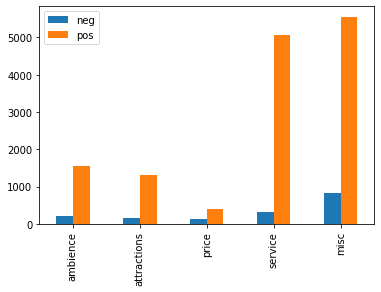

In [32]:
import matplotlib.pyplot as plt

# quick visualization
pd.DataFrame(aspect_sent).T.plot(kind='bar')
plt.show()

In [33]:
from collections import defaultdict

lowest = defaultdict()
highest = defaultdict()
for i in terms_dict:
    if terms_dict[i]:
        highest[i] = terms_dict[i].most_common()[:10]
        lowest[i] = terms_dict[i].most_common()[-10:]

In [34]:
highest_df = pd.DataFrame(highest)
lowest_df = pd.DataFrame(lowest)

In [35]:
import six
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax



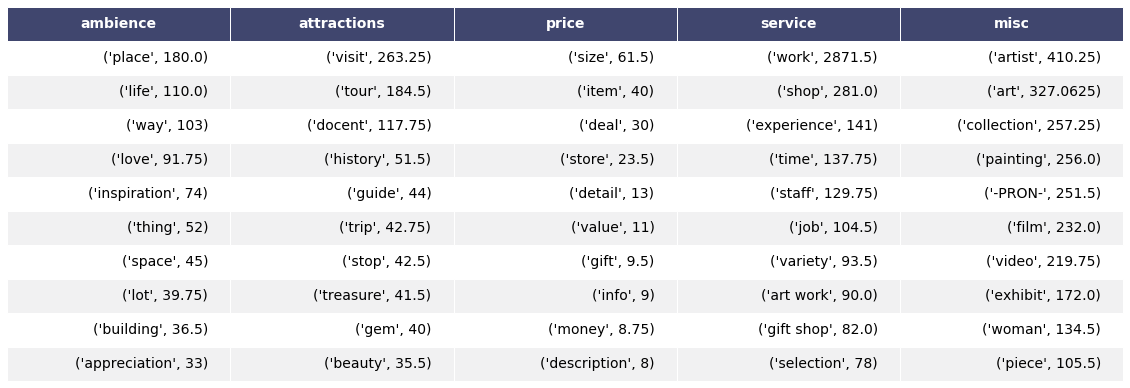

In [36]:
render_mpl_table(highest_df, header_columns=0, col_width=4.0)

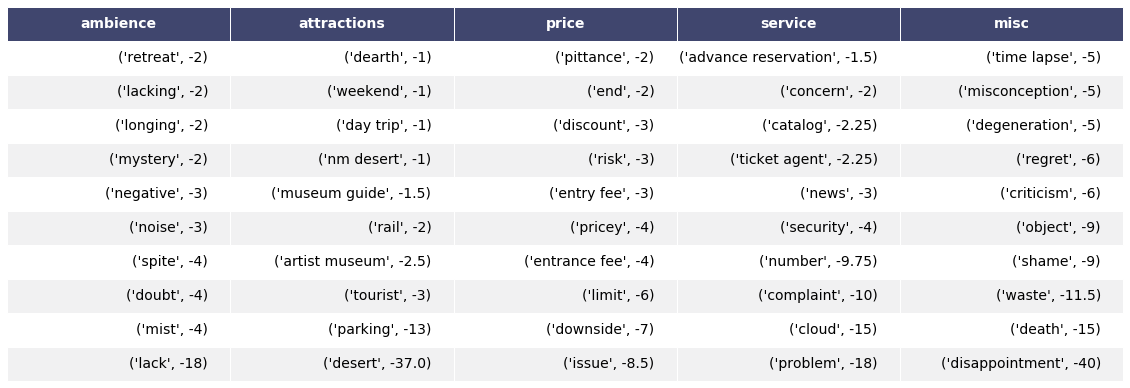

In [37]:
render_mpl_table(lowest_df, header_columns=0, col_width=4.0)